# Introduction à l'analyse bayésienne en écologie

Les statistiques bayésiennes forment une trousse d'outils à garder dans votre pack sack.

## Qu'est-ce que c'est?

En deux mots: modélisation probabiliste. Un approche de modélisation probabiliste se servant au mieux de l'information disponible. Pour calculer les probabilités d'une variable inconnu en mode bayésien, nous avons besoin:

* De données
* D'un modèle
* D'une idée plus ou moins précise du résultat avant d'avoir analysé les données

## Pourquoi utiliser?

> L'approche bayésienne est attirante puisqu'elle est utile. Son utilité découle dans une large mesure de sa simplicité. Sa simplicité permet l'investigation de modèles beaucoup plus complexes

## Comment l'utiliser?

Avec les modules [`pymc3`](http://docs.pymc.io/) et [`bambi`](https://github.com/bambinos/bambi)


## Faucons pélerins

Empruntons un exemple du livre [Introduction to WinBUGS for Ecologists: A Bayesian Approach to Regression, ANOVA and Related Analyses](https://www.elsevier.com/books/introduction-to-winbugs-for-ecologists/kery/978-0-12-378605-0), de Marc Kéry et examinons la masse de faucons pélerins. Mais alors que Marc Kéry utilise WinBUGS, un logiciel de résolution de problème en mode bayésien, nous utiliserons [PyMC3](https://pymc-devs.github.io/pymc3/).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Falco_peregrinus_-_01.jpg/1024px-Falco_peregrinus_-_01.jpg)
Source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Falco_peregrinus_-_01.jpg)

Pour une première approche, nous allons estimer la masse moyenne d'une population de faucons pélerins.

À titre de données, générons des nombres aléatoires. Cette stratégie permet de valider les statistiques en les comparant aux paramètre que l'on impose. Ici, nous imposons une moyenne de 600 grammes et un écart-type de 30 grammes. Générons une séries de données avec 20 échantillons.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

Text(0.5,1,'200 écchantillons')

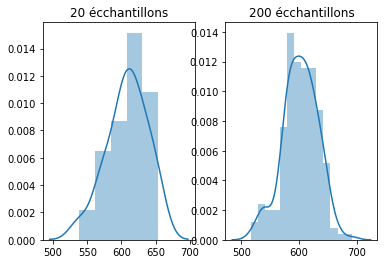

In [3]:
np.random.seed(63123) # fait en sorte que les mêmes nombres aléatoires sont tirés à chaque fois que la cellule est exécutée
y20 = np.random.normal(loc=600, scale=30, size=20)
y200 = np.random.normal(loc=600, scale=30, size=200)

plt.figure()
plt.subplot(121)
sns.distplot(y20)
plt.title('20 écchantillons')
plt.subplot(122)
sns.distplot(y200)
plt.title('200 écchantillons')

Calculons les statistiques de manière classique.

In [4]:
def confidence_interval(x, on='devidation', distribution = 't', confidence=0.95):
    m = np.mean(x)
    se = np.std(x)
    n = len(x)
    if distribution == 't':
        error = se * stats.t.ppf((1+confidence)/2., n-1)
    elif distribution == 'normal':
        error = se * stats.norm.ppf((1+confidence)/2.)
    if on == 'error':
        error = error/np.sqrt(n)
    return((m-error, m, m+error))

In [5]:
print('Déviation, 95%:', np.round(confidence_interval(y20, on='deviation', confidence=0.95), 2))
print('Erreur, 95%:', np.round(confidence_interval(y20, on='error', confidence=0.95), 2))
print('Écart-type:', np.round(np.std(y20), 2))

Déviation, 95%: [ 547.06  608.33  669.6 ]
Erreur, 95%: [ 594.63  608.33  622.03]
Écart-type: 29.28


In [6]:
print('Déviation, 95%:', np.round(confidence_interval(y20, on='deviation', distribution = 'normal', confidence=0.95), 2))
print('Erreur, 95%:', np.round(confidence_interval(y20, on='error', distribution = 'normal', confidence=0.95), 2))
print('Écart-type:', np.round(np.std(y20), 2))

Déviation, 95%: [ 550.95  608.33  665.71]
Erreur, 95%: [ 595.5   608.33  621.16]
Écart-type: 29.28


En faisant cela, vous prenez pour acquis que les données sont distribuées normalement. En fait, nous savons qu'elles devraient l'être pour de grands échantillons, puisque nous avons nous-même généré les données. Par contre, comme observateur par exemple de la série de 20 données générées, la distribution est définitivement asymétrique. Sous cet angle, la moyenne, ainsi que l'écart-type, pourraient être des paramètres biaisés.

Par ailleurs, il est instructif de visualiser jusqu'à quel point un petit échantillon peut aboutir à des distributions différentes. La cellule suivante peut être exécutées plusieurs fois.

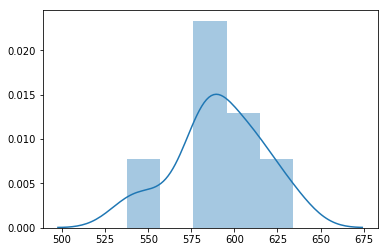

In [7]:
sns.distplot(np.random.normal(loc=600, scale=30, size=20))

Nous pouvons justifier le choix d'une loi normale par des connaissances a priori des distributions de masse parmi des espèces d'oiseau. Ou bien transformer les données pour rendre leur distribution normale.

## Statistiques d'une population

### PyMC3

PyMC3 isole la classe `Model`, qui initie la définition du problème, dans un segment de code indenté sous un contexte `with`. À l'intérieur de ce segment indenté, on définit la connaissance *a priori* sous forme de variables aléatoires non-observées (ou libres) selon une distribution. Les fonctions de vraissemblance sont quant à elles définient sous forme de variables aléatoires observées.

Prenons l'exemple des faucons pélerins.

In [8]:
import pymc3 as pm

Initions l'instance `model` de `pm.Model()` avec un *a priori* sur la masse moyenne. Disons que nous ne savons pas à quoi ressemble la moyenne du groupe a priori. Nous pouvons utiliser un a priori vague, où la masse moyenne peut prendre n'importe quelle valeur entre 0 et 2000 grammes, sans préférence: nous lui imposons donc un a priori selon une distribution uniforme.

https://people.duke.edu/~ccc14/sta-663/PyMC3.html

In [9]:
np.random.seed(17109)
with pm.Model() as model:
    mass_m = pm.Uniform('mass_m', lower=0, upper=2000)
    mass_sd = pm.Uniform('mass_sd', lower=0, upper=100)
    mass_pop = pm.Normal('mass_pop', mu=mass_m, sd=mass_sd) # vérifier si ça concorde avec l'analyse fréquentielle
    obs = pm.Normal('obs', mu=mass_m, sd=mass_sd, observed=y20)
    trace = pm.sample(1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:03<00:00, 429.82it/s]
/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.88478440697, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.879955980639, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bce484da0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6bd3f81898>]], dtype=object)

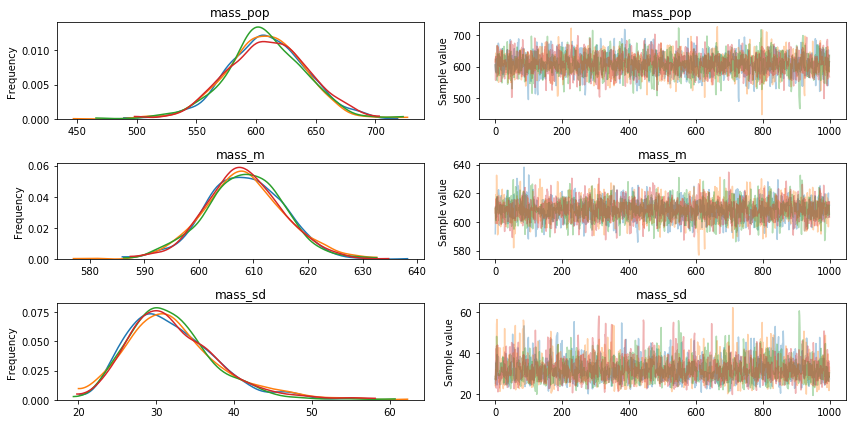

In [10]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bd2aa7ef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f6bd2b86978>], dtype=object)

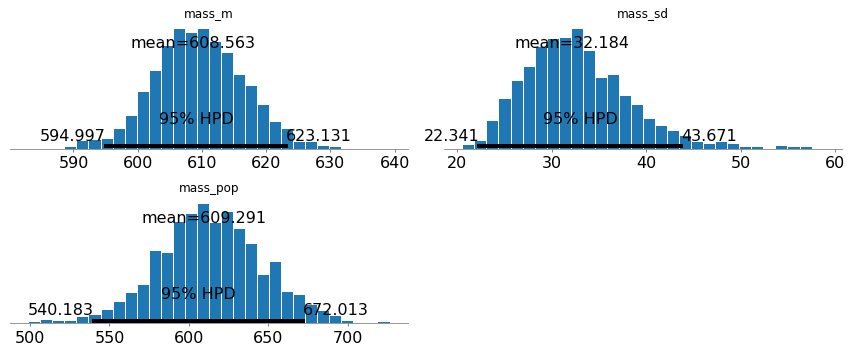

In [11]:
pm.plot_posterior(trace[:500], varnames=['mass_m', 'mass_sd', 'mass_pop']) # burn in [:500]

Population: entre 536 et 675. Braquette plus large que celle de l'analyse fréquenntielle. (uninformative prior).

In [12]:
print('Déviation, 95%:', np.round(confidence_interval(y20, on='deviation', confidence=0.95), 2))
print('Erreur, 95%:', np.round(confidence_interval(y20, on='error', confidence=0.95), 2))
print('Écart-type:', np.round(np.std(y20), 2))

Déviation, 95%: [ 547.06  608.33  669.6 ]
Erreur, 95%: [ 594.63  608.33  622.03]
Écart-type: 29.28


Rappelons les résultats obtenus en mode fréquentiels.

Même avec de vagues *a prioris* et peu de données, nous obtenons des résultats conformes à l'analyse fréquentielle. Néanmoins, les résultats peuvent être interprétés de manière différente. En ce qui a trait à la moyenne:

- **Fréquentiel**. Il y a une probabilité de 95% que mes données aient été générées à partir d'une moyenne se situant entre 595 et 622 grammes.

- **Bayésien**. Étant donnée mes connaissances (vagues) de la moyenne et de l'écart-type avant de procéder à l'analyse (*a priori*), il y a une probabilité de 95% que la moyenne de la masse de la population se situe entre 594 et 623 grammes.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bcc927588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6bcc835160>]], dtype=object)

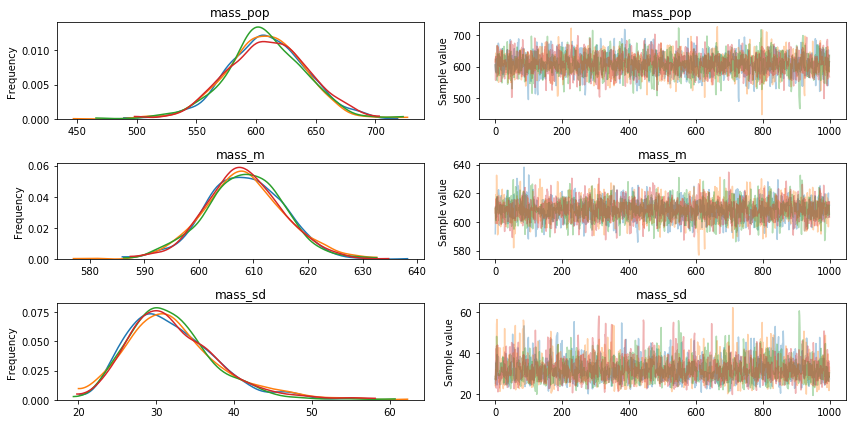

In [13]:
pm.traceplot(trace)

Nous avons maintenant une idée de la distribution de moyenne de la population. Mais, rarement, une analyse s'arrêtera à ce stade. Il arrive souvent que l'on doive comparer les pparamètres de deux, voire plusieurs groupes. Par exemple, comparer des populations vivants dans des écosystèmes différents, ou comparer un traitement à un placébo. Ou bien, comparer, dans une même population de faucons pélerins, l'envergure des ailes des mâles et celle des femelles.

## Test de t: Différence entre des groupes

Pour comparer des groupes, on exprime généralement une hypothèse nulle, qui typiquement pose qu'il n'y a pas de différence entre les groupes. Puis, on choisit un test statistique **pour déterminer si les distributions des données observées sont plausibles dans si l'hypothèse nulle est vraie**.

En d'autres mots, le test statistique exprime la probabilité que l'on obtienne les données obtenues s'il n'y avait pas de différence entre les groupes. 

Par exemple, si 

1. vous obtenez une *p-value* de moins de 0.05 après un test de comparaison et
2. l'hypothèse nulle pose qu'il n'y a pas de différence entre les groupes,

cela signifie qu'il y a une probabilité de 5% que vous ayiez obtenu ces données s'il n'y avait en fait pas de différence entre les groupe. Il serait donc peu probable que vos données euent été générées comme telles s'il n'y avait en fait pas de différence.

Exemple des envergures des ailes depuis Kéry (2010).

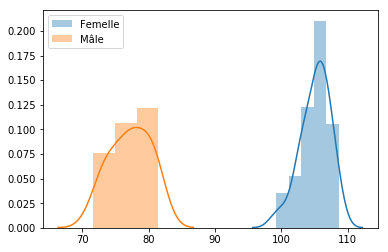

In [14]:
n_f = 30
moy_f = 105
n_m = 20
moy_m = 77.5
sd_fm = 2.75

np.random.seed(213156)
envergure_f = np.random.normal(loc=moy_f, scale=sd_fm, size=n_f)
envergure_m = np.random.normal(loc=moy_m, scale=sd_fm, size=n_m)
sns.distplot(envergure_f, label='Femelle')
sns.distplot(envergure_m, label='Mâle')
plt.legend()

In [15]:
print(pd.DataFrame(envergure_f).describe())
print(pd.DataFrame(envergure_m).describe())

                0
count   30.000000
mean   105.116181
std      2.220252
min     99.187298
25%    103.632750
50%    105.545896
75%    106.586969
max    108.694495
               0
count  20.000000
mean   77.213089
std     3.021790
min    71.612650
25%    74.806544
50%    77.309943
75%    79.936177
max    81.444380


Évaluer s'il y a une différence significative peut se faire avec un test de t (ou de Student).

In [16]:
stats.ttest_ind(envergure_f, envergure_m)

Ttest_indResult(statistic=37.645375691066626, pvalue=2.7192150379292623e-37)

La probabilité que les données ait été générées de la sorte si les deux groupes n'était semblables est très faible. On obtiendrait sensiblement les mêmes résultats avec une régression linéaire.

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
envergure = pd.DataFrame({'is_female': np.concatenate((np.repeat(1, n_f), np.repeat(0, n_m))),
                        'envergure': np.concatenate((envergure_f, envergure_m))})
linmod_envergure = smf.ols('envergure ~ is_female', data=envergure).fit()
linmod_envergure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              envergure   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1417.
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           2.72e-37
Time:                        11:17:55   Log-Likelihood:                -117.08
No. Observations:                  50   AIC:                             238.2
Df Residuals:                      48   BIC:                             242.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     77.2131      0.574    134.485      0.000      76.059      78.367
is_female     27.9031      0.741     37.645      0.000      26.413      29.393
==============================================================================
Omnibus:                        1.874   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.811
Skew:                          -0.396   Prob(JB):                        0.404
Kurtosis:                       2.509   Cond. No.                         2.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Les valeurs de t sont identiques, mais le modèle linéaire est plus informatif. Il nous apprend que l'envergure des ailes des femelles est plus en moyenne plus élevée de 28.8 cm que celle des mâles, avec un intervalle de confiance d'un niveau de 95% entre 27.4 et 30.1.

En mode bayésien, 

Utilisons l'information dérivée de statistiques classiques dans nos a priori. Oui-oui, on peut faire ça. Mais attention, un a priori trop précis ou trop collé sur nos données orientera le modèle vers une solution préalablement établie: ce qui e constituerait aucune avancée par rapport à l'*a priori*. Nous allons utiliser a priori pour les deux groupes la moyenne des deux groupes, et comme dispersion la moyenne le double de l'écart-type. Rappelons que cet écart-type est l'a priori de écart-type sur la moyenne, non pas de la population.

Procédons à l'instanciation d'un modèle `pm.Model()` dans l'objet `model`. Nous lui ajouterons des objets par bloc. D'abord, utilisons les tendances centrales des envergures des mâles et des femelles.

In [19]:
prior_moy = envergure['envergure'].mean()
prior_moy_sd = envergure['envergure'].std()
with pm.Model() as model:
    env_f_moy = pm.Normal('env_f_moy', prior_moy, sd=prior_moy_sd)
    env_m_moy = pm.Normal('env_m_moy', prior_moy, sd=prior_moy_sd)

Quant à l'écart-type de la population, un a priori vague et uniforme peut être utilisé, s'étalant uniformément entre 5 et 30 cm.

In [20]:
prior_sd_ll = 1
prior_sd_ul = 10
with model:
    env_f_sd = pm.Uniform('env_f_sd', lower=prior_sd_ll, upper=prior_sd_ul)
    env_m_sd = pm.Uniform('env_m_sd', lower=prior_sd_ll, upper=prior_sd_ul)

Il serait possible d'utiliser une distribution normale pour comparer les moyennes, ce qui serait l'équivalent de procéder à une ANOVA. Toutefois, comparons notre modèle bayésien au test de t avec une distribution de t (ou de Student). La distribution de t comprend aussi un paramètre $\nu$ qui fait converger vers la courbe normale un échantillon dont le nombre augmente. Kruschke (2012), cité dans un [tutoriel de test de t de PyMC3](https://pymc-devs.github.io/pymc3/notebooks/BEST.html), suggère une loi exponentielle comme a priori pour ce paramètre. Posons 20 comme espérance de la distribution exponentielle.

In [21]:
with model:
    nu_f = pm.Exponential('nu_f_minus_one', 1.0/(20-1)) + 1
    nu_m = pm.Exponential('nu_m_minus_one', 1.0/(20-1)) + 1

Dans PyMC3, la distribution de t est définie non pas selon un écart-type, mais selon une précision (`lam`), égale à l'inverse de la variance.

$$ precision = \frac{1}{ecart~type^2} = ecart~type^{-2} $$

In [22]:
with model:
    precision_f = env_f_sd**-2
    precision_m = env_m_sd**-2

    female = pm.StudentT('female', nu=nu_f, mu=env_f_moy, 
                         lam=precision_f, observed=envergure_f)
    male = pm.StudentT('male', nu=nu_m, mu=env_m_moy, 
                       lam=precision_m, observed=envergure_m)

In [23]:
with model:
    diff_of_means = pm.Deterministic('difference of means', env_f_moy - env_m_moy)
    diff_of_stds = pm.Deterministic('difference of stds', env_f_sd - env_m_sd)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((env_f_sd**2 + env_m_sd**2) / 2))


In [24]:
with model:
    trace = pm.sample(2000, init=None, njobs=4)

Assigned NUTS to env_f_moy
Assigned NUTS to env_m_moy
Assigned NUTS to env_f_sd_interval__
Assigned NUTS to env_m_sd_interval__
Assigned NUTS to nu_f_minus_one_log__
Assigned NUTS to nu_m_minus_one_log__
100%|██████████| 2500/2500 [00:14<00:00, 167.55it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bb8fdeb00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6bb8c53da0>]], dtype=object)

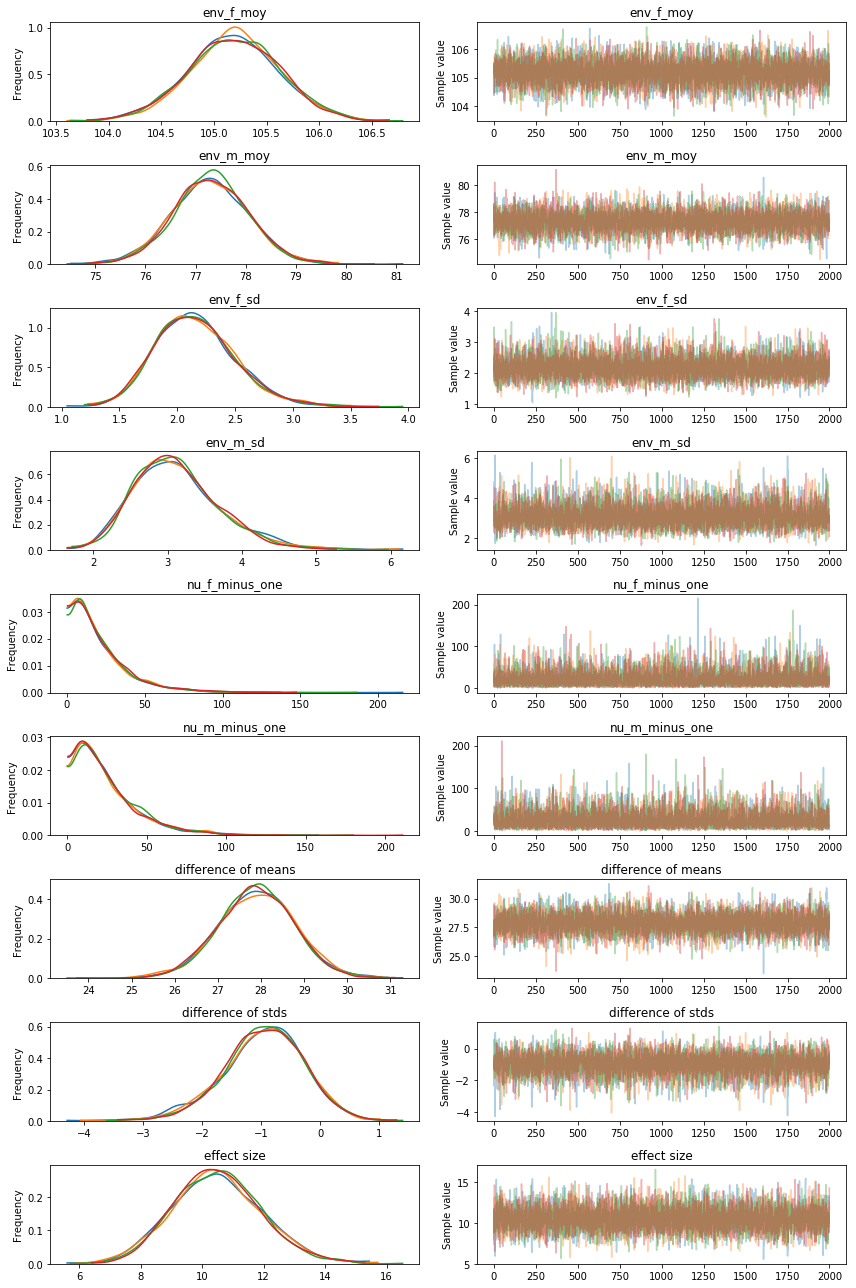

In [25]:
pm.traceplot(trace)

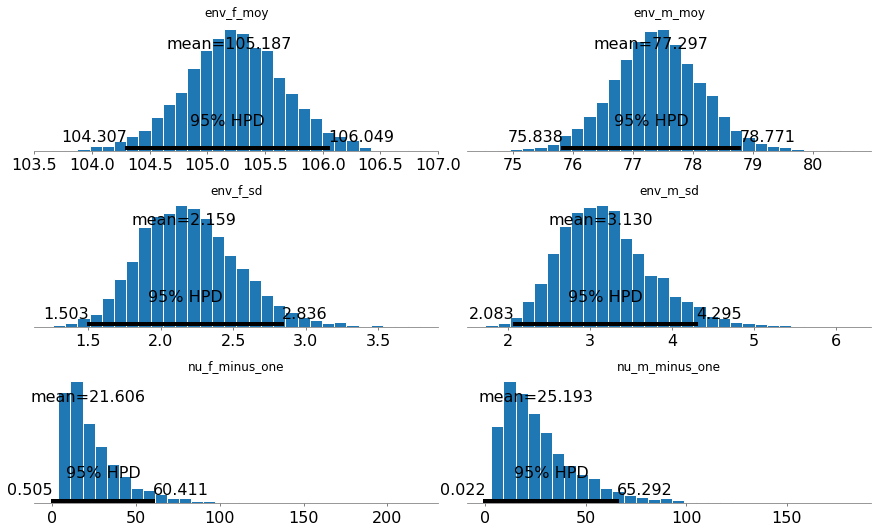

In [26]:
pm.plot_posterior(trace[500:],
                  varnames=['env_f_moy', 'env_m_moy', 'env_f_sd', 'env_m_sd', 'nu_f_minus_one', 'nu_m_minus_one']);

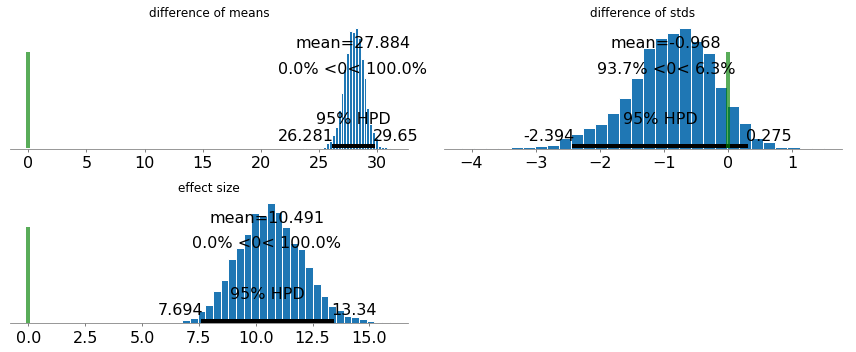

In [27]:
pm.plot_posterior(trace[1000:], varnames=['difference of means', 'difference of stds', 'effect size'], ref_val=0);

KeyError: 'env_f_sd_interval__'

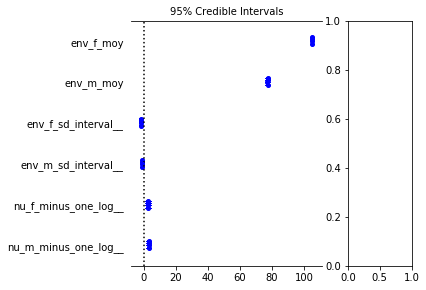

In [28]:
pm.forestplot(trace[500:], varnames=[v.name for v in model.vars])

In [ ]:
pm.summary(trace[500:], varnames=['difference of means', 'difference of stds', 'effect size'])

# Régression linéaire

Une test de t, comme une ANOVA, est une régression linéaire effectuée sur des catégories. *Voir chapitre 6 de Marc Kéry.*

Prenons l'exemple l'évolution de la population de renette faux-grillon (trouver les données)

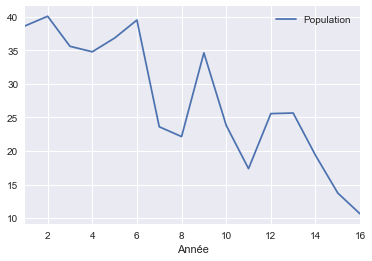

In [33]:
np.random.seed(56428)
intercept = 40
pente = -1.5
variance_residuelle = 25
annees = np.arange(1, 17, 1)
erreur = np.random.normal(loc=0, scale=np.sqrt(variance_residuelle), size=len(annees))
population = intercept + pente * annees + erreur
population_df = pd.DataFrame({'Année': annees,
                           'Population': population})
population_df.plot('Année', 'Population')

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
linmod_pop = smf.ols('Population ~ Année', data=population_df).fit()
linmod_pop.summary()

/home/essicolo/bin/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Population   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     44.70
Date:                Thu, 18 May 2017   Prob (F-statistic):           1.03e-05
Time:                        09:16:07   Log-Likelihood:                -46.945
No. Observations:                  16   AIC:                             97.89
Df Residuals:                      14   BIC:                             99.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.6061      2.551     16.703      0.000      37.135      48.077
Année         -1.7637      0.264     -6.686      0.000      -2.329      -1.198
==============================================================================
Omnibus:                        1.158   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                0.855
Skew:                           0.255   Prob(JB):                        0.652
Kurtosis:                       1.989   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

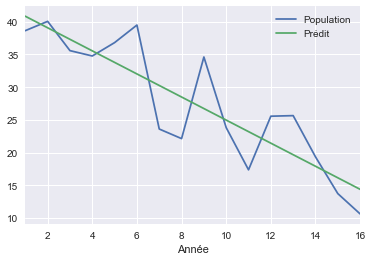

In [36]:
population_df['Prédit'] = linmod_pop.predict()
population_df.plot('Année', ['Population', 'Prédit'])

In [44]:
np.random.seed(10573)
with pm.Model() as model:
    intercept = pm.Normal('intercept', 40, sd=5)
    pente = pm.Normal('pente', 0, sd=5)
    erreur_sd = pm.HalfCauchy('erreur_sd', beta=10, testval=1.0)
    pop = pm.Normal('population', mu=intercept + pente*annees,
                    sd=erreur_sd, observed=population)
    # pm.glm.GLM.from_formula('population ~ annees', population_df) # class GLM non trouvée
    trace = pm.sample(2000, init=None, njobs=4)


Assigned NUTS to intercept
Assigned NUTS to pente
Assigned NUTS to erreur_sd_log_
100%|██████████| 2000/2000 [00:24<00:00, 80.09it/s] 


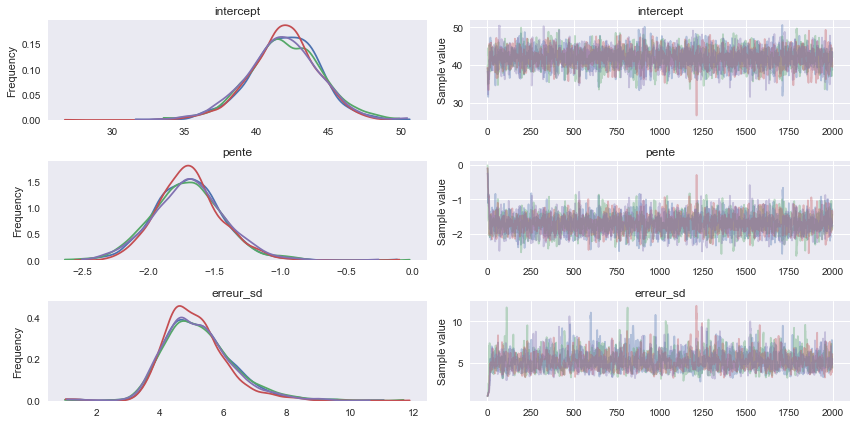

In [45]:
pm.traceplot(trace);

Il n'y a pas de manière unique d'aborder ce genre de problème. On doit choisir la manière de représenter les données (brutes, transformées, catégorisation, etc.) les données à inclure (valeurs aberrantes, données manquantes, effets aléatoires, etc.), le modèle utilisé (linéaire, non-linéaire) ainsi que les critères de significativité (p-value <= 0.05).

Les études scientifiques basent souvent ces choix arbitrairement, par conformité avec une littérature établie (Johnson 1999) REF. Cette approche est à haut risque de mauvaise interprétation des résultats (Goodman 1999) REF.

https://pymc-devs.github.io/pymc3/notebooks/BEST.html

## Régression linéaire mixte